<a href="https://colab.research.google.com/github/Ghiscode/Pengolahan-Citra-Digital/blob/main/Tugas-Salt-Pepper-Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mughis Fadhil A. Ridwan**

**20230040217**

**Pengolahan Citra Digital**

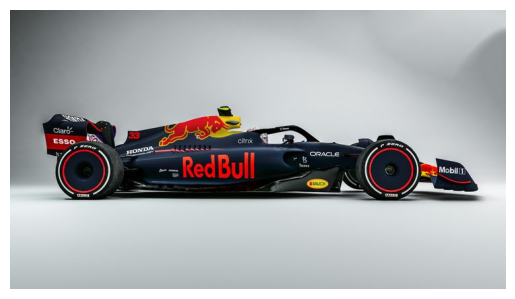

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

file_path = 'mobil.jpeg'
original_image = cv2.imread(file_path)

if original_image is None:
    print("ERROR: Tidak dapat memuat citra.")
else:
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    plt.imshow(original_image_rgb)
    plt.axis('off')
    plt.show()


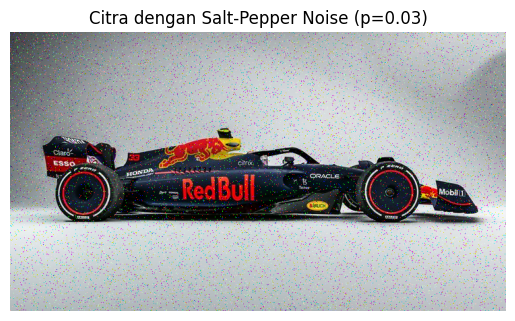

In [32]:
p = 0.03
noisy_image = np.copy(original_image)
H, W, C = original_image.shape # C adalah jumlah channel (3 untuk BGR)
total_pixels = H * W * C # Total piksel di semua channel

# Hitung jumlah titik noise
num_salt_pepper = int(np.ceil(p * total_pixels))

# Pilih lokasi noise secara acak di seluruh ruang (H x W x C)
coords = np.random.randint(0, [H, W, C], size=(num_salt_pepper, 3))

# Bagi noise menjadi salt (putih, 255) dan pepper (hitam, 0)
salt_count = num_salt_pepper // 2
pepper_count = num_salt_pepper - salt_count

# Menambahkan Salt (255)
for i in range(salt_count):
    h, w, c = coords[i]
    noisy_image[h, w, c] = 255

# Menambahkan Pepper (0)
for i in range(salt_count, num_salt_pepper):
    h, w, c = coords[i]
    noisy_image[h, w, c] = 0

# Tampilkan citra ber-noise (harus dikonversi ke RGB lagi untuk tampilan)
noisy_image_rgb = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)
plt.imshow(noisy_image_rgb)
plt.title(f'Citra dengan Salt-Pepper Noise (p={p})')
plt.axis('off')
plt.show()

In [36]:
def contraharmonic_filter_rgb(image, Q, k_size=3):
    filtered_channels = []

    pad_size = k_size // 2

    for c in range(image.shape[2]):
        channel = image[:, :, c]
        padded_channel = np.pad(channel, pad_size, mode='reflect')
        output_channel = np.zeros_like(channel, dtype=np.float64)

        for i in range(channel.shape[0]):
            for j in range(channel.shape[1]):
                region = padded_channel[i:i+k_size, j:j+k_size].astype(np.float64)

                # Rumus Contraharmonic
                numerator = np.sum(region**(Q + 1))
                denominator = np.sum(region**Q)

                if denominator == 0:
                    output_channel[i, j] = region[pad_size, pad_size]
                else:
                    output_channel[i, j] = numerator / denominator

        filtered_channels.append(output_channel)

    restored_image = cv2.merge([
        np.clip(filtered_channels[0], 0, 255).astype(np.uint8),
        np.clip(filtered_channels[1], 0, 255).astype(np.uint8),
        np.clip(filtered_channels[2], 0, 255).astype(np.uint8)
    ])
    return restored_image

results = {}

# a. Median Filter
kernel_size = 3
median_restored = cv2.medianBlur(noisy_image, kernel_size)
results['Median Filter'] = median_restored

# b. Mean Filter
kernel_mean = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
mean_restored = cv2.filter2D(noisy_image, -1, kernel_mean)
results['Mean Filter'] = mean_restored

# c. Contraharmonic Filter Q = 1.5
Q_salt = 1.5
ch_salt_restored = contraharmonic_filter_rgb(noisy_image, Q_salt)
results[f'Contraharmonic (Q={Q_salt})'] = ch_salt_restored

# d. Contraharmonic Filter Q = -1.5
Q_pepper = -1.5
ch_pepper_restored = contraharmonic_filter_rgb(noisy_image, Q_pepper)
results[f'Contraharmonic (Q={Q_pepper})'] = ch_pepper_restored

/tmp/ipython-input-764479692.py:16: RuntimeWarning: divide by zero encountered in power
  numerator = np.sum(region**(Q + 1))
/tmp/ipython-input-764479692.py:17: RuntimeWarning: divide by zero encountered in power
  denominator = np.sum(region**Q)
/tmp/ipython-input-764479692.py:22: RuntimeWarning: invalid value encountered in scalar divide
  output_channel[i, j] = numerator / denominator
/tmp/ipython-input-764479692.py:27: RuntimeWarning: invalid value encountered in cast
  np.clip(filtered_channels[0], 0, 255).astype(np.uint8),
/tmp/ipython-input-764479692.py:28: RuntimeWarning: invalid value encountered in cast
  np.clip(filtered_channels[1], 0, 255).astype(np.uint8),
/tmp/ipython-input-764479692.py:29: RuntimeWarning: invalid value encountered in cast
  np.clip(filtered_channels[2], 0, 255).astype(np.uint8)


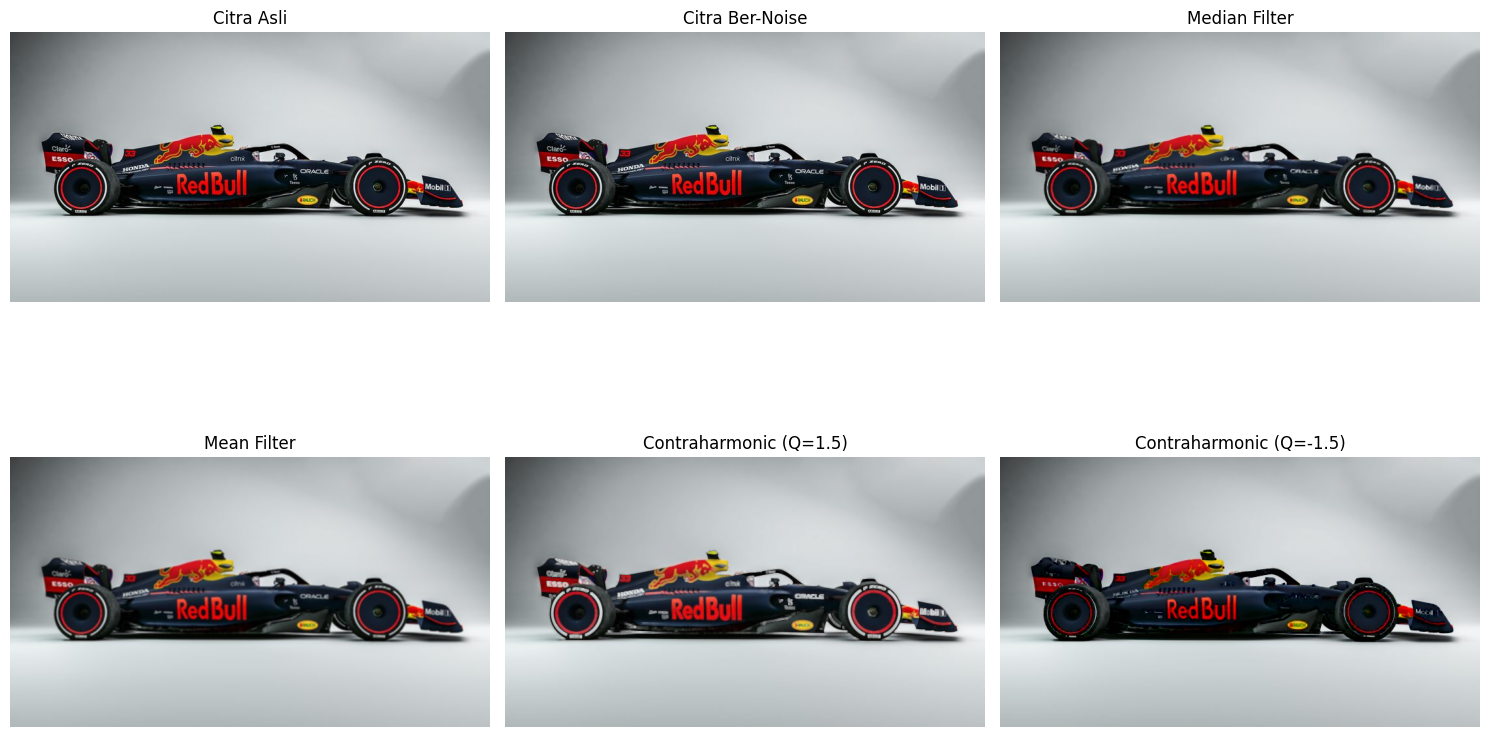


--- Tabel Perbandingan Kuantitatif (MSE & PSNR) ---
| Metode Filter           |      MSE |    PSNR |
|:------------------------|---------:|--------:|
| Median Filter           |  58.9644 | 30.4249 |
| Mean Filter             |  89.0565 | 28.6341 |
| Contraharmonic (Q=1.5)  | 312.507  | 23.1822 |
| Contraharmonic (Q=-1.5) | 334.745  | 22.8837 |


In [37]:
def calculate_mse_psnr(original, restored):
    original_f = original.astype(np.float64)
    restored_f = restored.astype(np.float64)

    mse_value = np.mean((original_f - restored_f) ** 2)

    # Hitung PSNR
    MAX_I = 255.0
    if mse_value == 0:
        psnr_value = float('inf')
    else:
        psnr_value = 10 * np.log10((MAX_I ** 2) / mse_value)

    return mse_value, psnr_value

final_data = {}
for name, image in results.items():
    mse_val, psnr_val = calculate_mse_psnr(original_image, image)
    final_data[name] = {'MSE': mse_val, 'PSNR': psnr_val, 'Image': image}

# Tampilkan Visual
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

images_to_display = [
    ('Citra Asli', original_image),
    ('Citra Ber-Noise', noisy_image)
] + [(name, data['Image']) for name, data in final_data.items()]

for i, (name, img_bgr) in enumerate(images_to_display):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Tampilkan Tabel Kuantitatif
import pandas as pd
table_data = []
for name, data in final_data.items():
    table_data.append([name, f"{data['MSE']:.4f}", f"{data['PSNR']:.4f}"])

df_results = pd.DataFrame(table_data, columns=['Metode Filter', 'MSE', 'PSNR'])

print("\n--- Tabel Perbandingan Kuantitatif (MSE & PSNR) ---")
print(df_results.to_markdown(index=False))

**1. Metode mana terbaik untuk kasus Anda? :** Median Filter adalah metode terbaik untuk menghilangkan Salt-Pepper noise pada kasus saya

**2. Mengapa metode lain kurang efektif? :** Metode lain kurang efektif itu karena sifat nya yang tidak sesuai dengan noise yang dihadapi, Mean filter yang gagal meratakan piksel sehingga citra hasil restorasi terlihat buram dan untuk contraharmonic memiliki kinerja terburuk karena filter tersebut dirancang untuk mengatasi noise unipolar yang menjadikan ketika di terapkan pada noise bipolar citra akan terlihat mengalami distorsi serius dan secara signifikan gagal merestorasi kedua jenis noise secara seimbang, menghasilkan PSNR terendah.



